# Simulation and parameter recovery of dynamic foraging task.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask
from aind_dynamic_foraging_models.generative_model import ForagerCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize an agent

In [25]:
# Initialize the model
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0,
)

# Create the task environment
task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

## Simulation the task

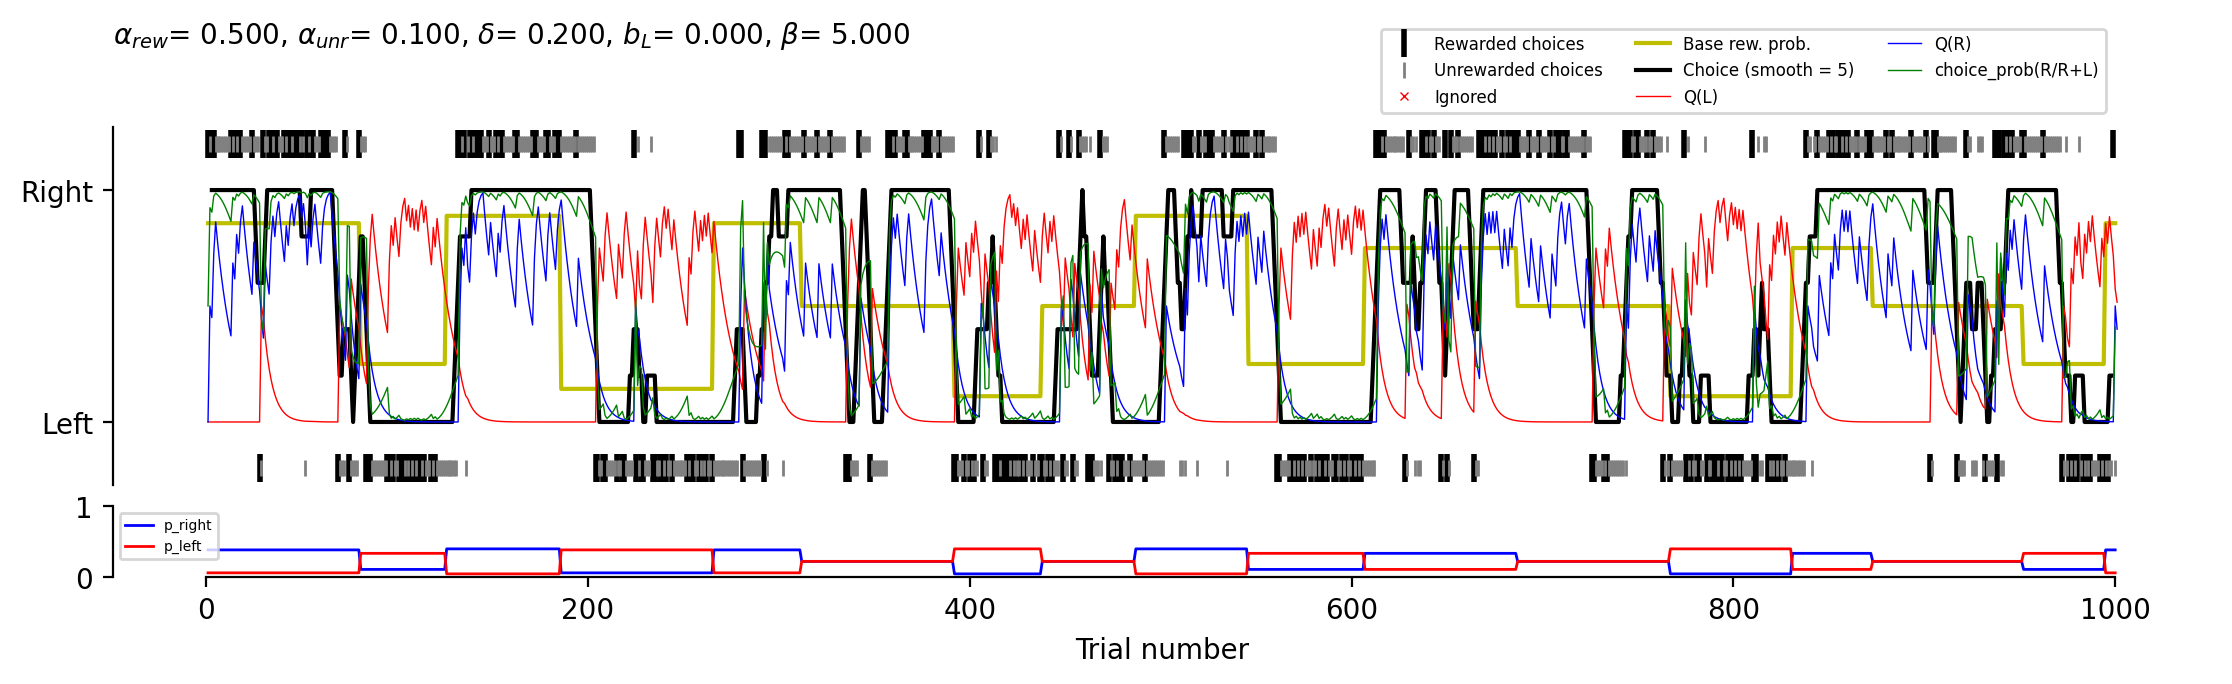

In [26]:
# Run the model
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery

In [28]:
# Fit the model to recover parameters
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2024-08-30 21:02:21,219 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 278.66081064312925
differential_evolution step 3: f(x)= 271.07233761947083
differential_evolution step 4: f(x)= 271.07233761947083
differential_evolution step 5: f(x)= 271.07233761947083
differential_evolution step 6: f(x)= 267.7258166159626
differential_evolution step 7: f(x)= 267.7258166159626
differential_evolution step 8: f(x)= 267.7258166159626
differential_evolution step 9: f(x)= 261.55107374493673
differential_evolution step 10: f(x)= 261.1578133089714
differential_evolution step 11: f(x)= 261.1578133089714
differential_evolution step 12: f(x)= 259.92281388759886
differential_evolution step 13: f(x)= 258.0116776498438
differential_evolution step 14: f(x)= 258.0116776498438
differential_evolution step 15: f(x)= 258.0116776498438
differential_evolution step 16: f(x)= 258.0116776498438
differential_evolution step 17: f(x)= 258.0116776498438
differential_evolution step 18: f(x)= 258.011677649

In [30]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6011', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884625494
Prediction accuracy full dataset: 0.902



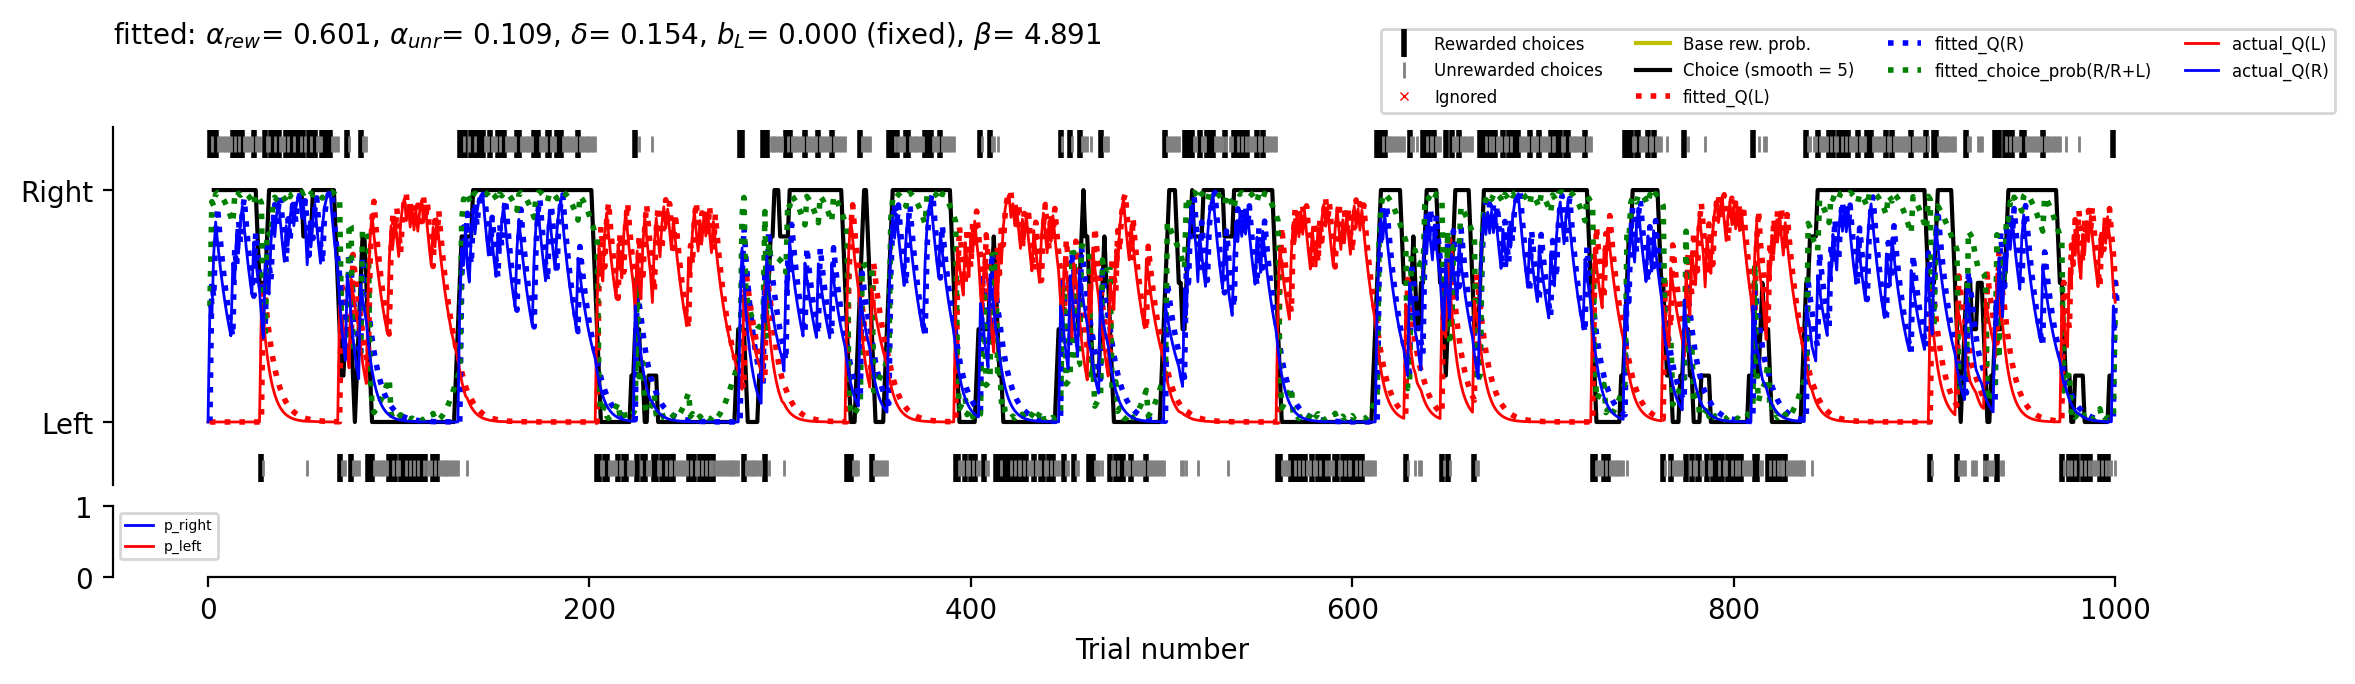

In [31]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)